# Introduction

- The code in this python jupyter notebook is to be used jointly with a GeoSpock DB Discovery deployment for which you can sign up [here](https://geospock.com/en/product/geospock-db-discovery/). 
- GeoSpock DB Discovery provides a way to experience the power of GeoSpock DB without having to pay any license fees. Typically available for a short trial period, GeoSpock DB Discovery gives you control of your own query engine and allows you to run queries using standard ANSI SQL against a range of pre-selected datasets.
- It is recommended to execute the following code using a cluster of no less than 10 nodes.
- Finally, further documentation on GeoSpock DB Discovery and geospatial queries can be found [here](https://docs.geospock.com/discovery/about/).

# Smart Singapore - Data exploration

- Below are snippets of code that we used to generate the graphs to help visualize the datasets available on GeoSpock DB Discovery.

- We first of all load some libraries, define a few helpful functions, and set up a connection to the database, before launching the investigation.

### Import libraries

In [1]:
import prestodb
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_columns',500)

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter

import keplergl
import json

import datetime

from os.path import expanduser

import seaborn as sns

## Auxiliary Functions

In [2]:
def getcolnames(cnn,tbl):
    cur=cnn.cursor()
    querycolumnnames="SHOW COLUMNS FROM geospock.default."+tbl
    cur.execute(querycolumnnames)
    cols=cur.fetchall()
    colnames = [col[0] for col in cols]
    cur.close()
    return colnames

In [3]:
def showtables(cnn):
    cur=cnn.cursor()
    querycolumnnames='SHOW TABLES FROM geospock.default'
    cur.execute(querycolumnnames)
    cols=cur.fetchall()
    colnames = [col[0] for col in cols]
    cur.close()
    return colnames

In [4]:
def getschemas(cnn):
    cur=cnn.cursor()
    querycolumnnames='SHOW SCHEMAS FROM geospock'
    cur.execute(querycolumnnames)
    cols=cur.fetchall()
    colnames = [col[0] for col in cols]
    cur.close()
    return colnames

In [5]:
def runquery(cnn,cls,querytext):
    sttime = datetime.datetime.now()
    print("Starting query at: "+str(sttime)+".....")
    cur = cnn.cursor()
    cur.execute(querytext)
    rows = cur.fetchall()
    cur.close()
    endtime = datetime.datetime.now()
    print("Finished query at: "+str(endtime)+".")
    tdelt=(endtime-sttime).seconds
    print("Query duration: "+str(tdelt)+" seconds.")
    print("Rows returned: "+str(len(rows)))
    return pd.DataFrame(rows,columns=cls)

In [6]:
def runqueryvanilla(cnn,querytext):
    cur = cnn.cursor()
    cur.execute(querytext)
    rows = cur.fetchall()
    cur.close()
    return rows

In [7]:
def load_kepler_config(config_filename):
    with open(config_filename, 'r') as f:
        config = json.load(f)
    print(config_filename, 'opened')        
    return config

In [8]:
def save_kepler_config(config, config_filename, write_kepler):
    if write_kepler:
        with open(config_filename, 'w') as f:
            json.dump(config, f)
        print(config_filename, 'saved')
    else:
        print(config_filename, 'NOT saved')

In [9]:
def create_dir(dirName):
    if not os.path.exists(dirName):
        os.mkdir(dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")

In [10]:
def makeconn(hstb,uname,pswd, authentication):
    if authentication == 'HTTP':
        return prestodb.dbapi.connect(
            host=hstb,
            port=80,
            user=uname.strip(),
            catalog='geospock',
            schema='default',
            http_scheme='http'
            )
    elif authentication == 'HTTPS':
        return prestodb.dbapi.connect(
        host=hstb,
        port=443,
        user=uname.strip(),
        catalog='geospock',
        schema='default',
        http_scheme='https',    
        auth=prestodb.auth.BasicAuthentication(uname.strip(), pswd.strip())
        )
    else:
        print('Aunthentication method not valid')

In [11]:
def write_data(input_df, filename, dir_data, write_data_flag):
    if write_data_flag:
        filename = os.path.join(dir_data, filename)+'.csv'
        input_df.to_csv(filename, header=True, index=False)
        print('Data saved at: ', filename)
    else:
        print(write_data_flag, ' set to false, thus data not saved.')

In [12]:
def time_queries(signal, timestamp, table, prefix, dir_images, time_range = """ BETWEEN TIMESTAMP '2018-08-30 00:00:00' AND TIMESTAMP '2018-08-30 12:00:00'"""):

    QUERY = """
    SELECT """ + timestamp + """, """ + signal + """
      FROM geospock.default.""" + table + """
     WHERE """+ timestamp + time_range
    
    cols            = [ timestamp, signal]
    data            = runquery(newconn, cols, QUERY)
    data[timestamp] = pd.to_datetime(data[timestamp])

    plt.figure(figsize = (16, 5))
    g = sns.lineplot(data = data, x = timestamp, y = signal)
    plt.xticks(rotation = 0, fontsize = 14)
    plt.yticks(rotation = 0, fontsize = 14)
    plt.xlabel(timestamp, fontsize=16)
    plt.ylabel(signal, fontsize=16)
    
    plot_name = os.path.join(dir_images, prefix + table +'_'+ signal + '_' + timestamp + '.png')
    g.figure.savefig(plot_name);
    print('Figure saved at: ', plot_name)

# Specify Authentication Methods

### HTTP authentication method
### If you are NOT using the SSL option in the Cloudformation script the following parameters are used in the connection functions below.
- host = assign real value, e.g. `disco-Prest-26Z2LD7S11IPM-2177915702.ap-southeast-1.elb.amazonaws.com`
- port = 80
- username = 'username' 
- password = ''
- http_scheme = 'http'
- commented #auth=prestodb.auth.BasicAuthentication(uname.strip(), pswd.strip())

### HTTPS authentication method
### If you ARE using the SSL option in the Cloudformation script the following parameters are used in the connection functions below.
- host = assign its real value e.g. `discovery.companyname.com`
- port = 443
- username = 'username' 
- password = ''
- http_scheme = 'https'
- auth=prestodb.auth.BasicAuthentication(uname.strip(), pswd.strip())

In [13]:
# Remember to change GeoSpockDBDiscoveryHostname for its respective value
# e.g disco-Prest-26Z2LD7S11IPM-2177915702.ap-southeast-1.elb.amazonaws.com 
# or discovery.companyname.com 
# depending if HTTP or HTTPS is to be used
# username and password are to be left with these default values
host            = """GeoSpockDBDiscoveryHostname"""
username       = 'username'
password       = ''
authentication = '' # HTTP or HTTPS
newconn        = makeconn(host, username, password,authentication)

### Specify if to download data to local or modify Kepler configuration

In [14]:
write_data_flag   = True
write_kepler_flag = False

In [15]:
dir_data   = "local_data_exploration"
dir_kepler = "kepler_config_data_exploration"
dir_images = "images_data_exploration"
create_dir(dir_data)
create_dir(dir_kepler)
create_dir(dir_images)

Directory  local_data_exploration  already exists
Directory  kepler_config_data_exploration  already exists
Directory  images_data_exploration  already exists


# 1_sg_air_temperature

Starting query at: 2020-12-10 22:05:18.370527.....
Finished query at: 2020-12-10 22:05:22.328719.
Query duration: 3 seconds.
Rows returned: 9582
Figure saved at:  images_data_exploration/1_sg_wind_speed_wind_speed_value_original_timestamp.png


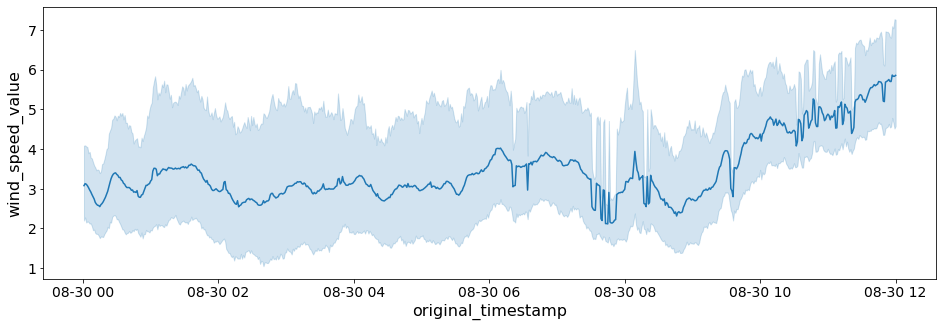

In [16]:
time_queries(signal = 'wind_speed_value', timestamp = 'original_timestamp', table = 'sg_wind_speed', prefix = '1_', dir_images = dir_images)

# 2_sg_erp1_camera_location

In [17]:
QUERY_erp1cameras = """
SELECT long, lat, geometry, id
  FROM geospock.default.sg_erp1_camera_location
"""

In [18]:
erp1camerascols = ['longitude', 'latitude', 'geometry', 'id']
# Run query live
erp1cameras = runquery(newconn, erp1camerascols, QUERY_erp1cameras)

Starting query at: 2020-12-10 22:05:39.277537.....
Finished query at: 2020-12-10 22:05:39.796776.
Query duration: 0 seconds.
Rows returned: 105


In [19]:
write_data(erp1cameras, 'erp1cameras', dir_data, write_data_flag)

Data saved at:  local_data_exploration/erp1cameras.csv


In [20]:
werp1cameras = keplergl.KeplerGl(height=500)
werp1cameras.add_data(data = erp1cameras, name="erp1cameras")
#Read widget config
config_filename_werp1cameras = os.path.join(dir_kepler, 'config_werp1cameras.json')
werp1cameras.config          = load_kepler_config(config_filename_werp1cameras)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_werp1cameras.json opened


In [21]:
werp1cameras

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'epnpfui', 'type': …

In [22]:
# Write widget config
save_kepler_config(werp1cameras.config, config_filename_werp1cameras, write_kepler_flag)

kepler_config_data_exploration/config_werp1cameras.json saved


# 3_sg_erp2_synthesis

In [23]:
VehicleIDs = ('a03eb904e5ddd8b15f150d504a768341', 'ee585f6176854d02649681497f64f9e3', '101171f846d8b07abfab645dd8f25ee', 'bee94704913a32e1e545bef7a9a8d921',
 'e01d3b07a000038e71f1d641fea09c70', 'afe662146cb27c9443bfbb1d1c2b7fbe', 'cfeec0468475237d81292363f78ac986', '1d7522dd5864b922447d231d7028571d',
 '26927f986d623d29708dfe5ea58cceec', '7d7058ac9c96e443e22bc4e96e5baed8', '532f0f812009ca04f9cbc1b31fd524ed', '78c5cf9bcdbb8e94aa45028abd1b524e',
 'cb8373cda4f9b225bb1da66f6b50465d', '59fc1f50766688bbd136302488ebbc5c', '7dfc598a852f05e7f1265487ebc72451', '18f8580f9d784c108f7128f1166f0a72',
 'dec4665d82d1a0a490670dec1263f7a6', 'e515101db5481478751f0afdf3c29f90', '80d04c9b958ef1cd5700a2c199a92507', 'a75dac493e0ab49fbd68b7bbce724496')

In [24]:
QUERY_erp2 ="""
SELECT erppoints.* 
  FROM geospock.default.sg_erp2_synthesis AS erppoints 
 WHERE erppoints.erp_vehicle_id IN """+str(tuple(VehicleIDs))+"""
   AND erppoints.timestamp BETWEEN TIMESTAMP '2019-08-30 00:00:00' AND TIMESTAMP '2019-08-31 00:00:00'
"""

In [25]:
erpcols               = ['longitude', 'latitude', 'erp_vehicle_id', 'timestamp', 'erp_vehicle_types']
# Run query live
erp2 = runquery(newconn, erpcols, QUERY_erp2)

Starting query at: 2020-12-10 22:05:39.952028.....
Finished query at: 2020-12-10 22:06:47.284189.
Query duration: 67 seconds.
Rows returned: 27230


In [26]:
write_data(erp2, 'erp2', dir_data, write_data_flag)

Data saved at:  local_data_exploration/erp2.csv


In [27]:
werp2 = keplergl.KeplerGl(height=500)
werp2.add_data(data=erp2,name="Trajectories")
#Read widget config
config_filename_werp2 = os.path.join(dir_kepler, 'config_werp2.json')
werp2.config          = load_kepler_config(config_filename_werp2)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_werp2.json opened


In [28]:
werp2

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'rqls3ca', 'type': …

In [29]:
# Write widget config
save_kepler_config(werp2.config, config_filename_werp2, write_kepler_flag)

kepler_config_data_exploration/config_werp2.json saved


# 4_sg_planning_area_census

In [30]:
QUERY_planningareacensus = """
SELECT long, lat, geometry, name
  FROM geospock.default.sg_planning_area_census
"""

In [31]:
planningareacensuscols = ['longitude', 'latitude', 'geometry', 'name']
# Run query live
planningareacensus = runquery(newconn, planningareacensuscols, QUERY_planningareacensus)

Starting query at: 2020-12-10 22:06:48.169516.....
Finished query at: 2020-12-10 22:06:48.738082.
Query duration: 0 seconds.
Rows returned: 55


In [32]:
write_data(planningareacensus, 'planningareacensus', dir_data, write_data_flag)

Data saved at:  local_data_exploration/planningareacensus.csv


In [33]:
wplanningareacensus = keplergl.KeplerGl(height=500)
wplanningareacensus.add_data(data = planningareacensus, name="planningareacensus")
#Read widget config
config_filename_wplanningareacensus = os.path.join(dir_kepler, 'config_wplanningareacensus.json')
wplanningareacensus.config          = load_kepler_config(config_filename_wplanningareacensus)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_wplanningareacensus.json opened


In [34]:
wplanningareacensus

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'sf9sluc', 'type': …

In [35]:
# Write widget config
save_kepler_config(wplanningareacensus.config, config_filename_wplanningareacensus, write_kepler_flag)

kepler_config_data_exploration/config_wplanningareacensus.json saved


# 5_sg_pm25

Starting query at: 2020-12-10 22:06:48.783338.....
Finished query at: 2020-12-10 22:06:50.853483.
Query duration: 2 seconds.
Rows returned: 55
Figure saved at:  images_data_exploration/5_sg_pm25_pm_25_sensor_value_original_timestamp.png


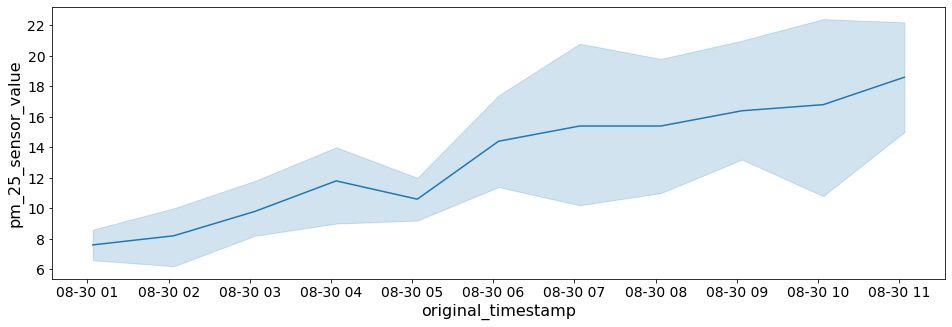

In [36]:
time_queries(signal = 'pm_25_sensor_value', timestamp = 'original_timestamp', table = 'sg_pm25', prefix = '5_', dir_images = dir_images)

# 6_sg_psi

Starting query at: 2020-12-10 22:06:51.372326.....
Finished query at: 2020-12-10 22:06:53.543815.
Query duration: 2 seconds.
Rows returned: 792
Figure saved at:  images_data_exploration/6_sg_psi_sensorvalue_timestamp.png


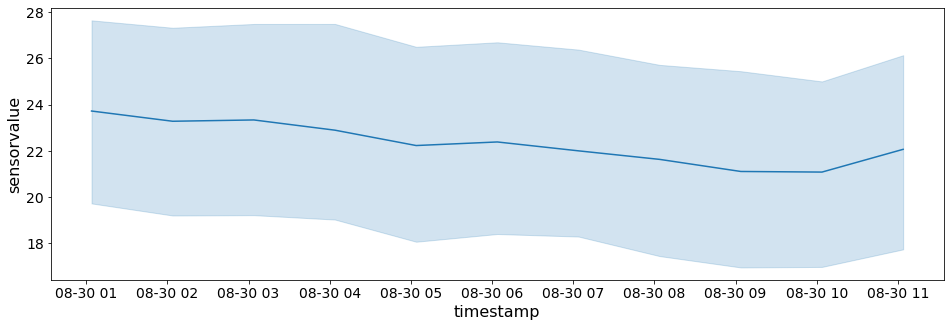

In [37]:
time_queries(signal = 'sensorvalue', timestamp = 'timestamp', table = 'sg_psi', prefix = '6_', dir_images = dir_images)

# 7_sg_rainfall

Starting query at: 2020-12-10 22:06:54.008088.....
Finished query at: 2020-12-10 22:07:02.329617.
Query duration: 8 seconds.
Rows returned: 15643
Figure saved at:  images_data_exploration/7_sg_rainfall_rainfall_value_original_timestamp.png


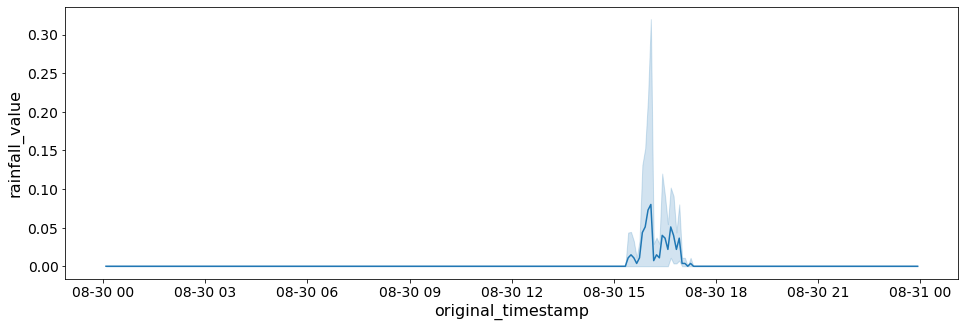

In [38]:
time_queries(signal = 'rainfall_value', timestamp = 'original_timestamp', table = 'sg_rainfall', prefix = '7_', dir_images = dir_images, 
             time_range = """ BETWEEN TIMESTAMP '2018-08-30 00:00:00' AND TIMESTAMP '2018-08-30 23:59:59'""")

# 8_sg_region_census

In [39]:
QUERY_regioncensus = """
SELECT longitude, latitude, geometry, name
  FROM geospock.default.sg_region_census
"""

In [40]:
regioncensuscols = ['longitude', 'latitude', 'geometry', 'name']
# Run query live
regioncensus = runquery(newconn, regioncensuscols, QUERY_regioncensus)

Starting query at: 2020-12-10 22:07:09.194251.....
Finished query at: 2020-12-10 22:07:10.174571.
Query duration: 0 seconds.
Rows returned: 5


In [41]:
write_data(regioncensus, 'regioncensus', dir_data, write_data_flag)

Data saved at:  local_data_exploration/regioncensus.csv


In [42]:
wregioncensus = keplergl.KeplerGl(height=500)
wregioncensus.add_data(data = regioncensus, name="wregioncensus")
#Read widget config
config_filename_wregioncensus = os.path.join(dir_kepler, 'config_wregioncensus.json')
wregioncensus.config                = load_kepler_config(config_filename_wregioncensus)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_wregioncensus.json opened


In [43]:
wregioncensus

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'z0vqvh7', 'type': …

In [44]:
# Write widget config
save_kepler_config(wregioncensus.config, config_filename_wregioncensus, write_kepler_flag)

kepler_config_data_exploration/config_wregioncensus.json saved


# 9_sg_relative_humidity

Starting query at: 2020-12-10 22:07:10.217599.....
Finished query at: 2020-12-10 22:07:17.041367.
Query duration: 6 seconds.
Rows returned: 11229
Figure saved at:  images_data_exploration/9_sg_relative_humidity_value_timestamp.png


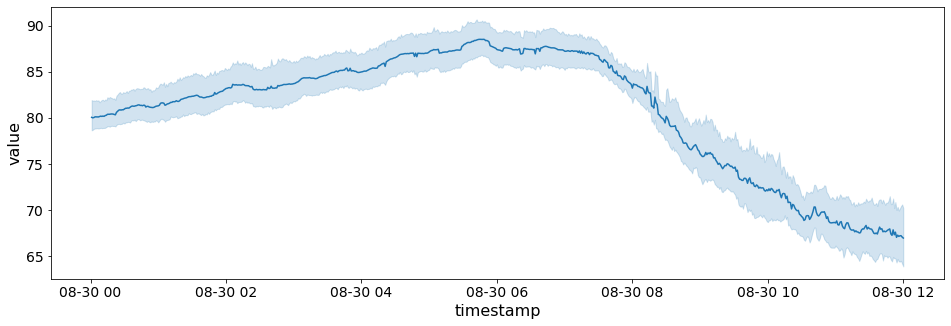

In [45]:
time_queries(signal = 'value', timestamp = 'timestamp', table = 'sg_relative_humidity', prefix = '9_', dir_images = dir_images)

# 10_sg_road_segments

In [46]:
QUERY_roadsegments = """
SELECT *
  FROM geospock.default.sg_road_segments
"""

In [47]:
roadsegmentscols = ['longitude', 'latitude', 'linkid', 'roadname', 'roadcategory', 'geometry']
# Run query live
roadsegments = runquery(newconn, roadsegmentscols, QUERY_roadsegments)

Starting query at: 2020-12-10 22:07:33.847800.....
Finished query at: 2020-12-10 22:07:35.623519.
Query duration: 1 seconds.
Rows returned: 58780


In [48]:
write_data(roadsegments, 'roadsegments', dir_data, write_data_flag)

Data saved at:  local_data_exploration/roadsegments.csv


In [49]:
wroadsegments = keplergl.KeplerGl(height=500)
wroadsegments.add_data(data = roadsegments, name = "roadsegments")
#Read widget config
config_filename_wroadsegments = os.path.join(dir_kepler, 'config_wroadsegments.json')
wroadsegments.config          = load_kepler_config(config_filename_wroadsegments)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_wroadsegments.json opened


In [50]:
wroadsegments

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '6jknx7e', 'type': …

In [51]:
# Write widget config
save_kepler_config(wroadsegments.config, config_filename_wroadsegments, write_kepler_flag)

kepler_config_data_exploration/config_wroadsegments.json saved


# 11_sg_speed_bands

In [52]:
QUERY_speedbands = """
SELECT *
  FROM geospock.default.sg_speed_bands AS speedbandtable
 WHERE speedbandtable.timestamp BETWEEN TIMESTAMP '2019-08-30 15:00:00' AND TIMESTAMP '2019-08-30 15:05:00'
"""

In [53]:
speedbandcols = ['linkid', 'timestamp', 'latitude1',\
                          'longitude1', 'roadname', 'roadcategory',\
                          'speedband', 'minimumspeed', 'maximumspeed', 'latitude2', 'longitude2']
# Run query live
speedbands    = runquery(newconn, speedbandcols, QUERY_speedbands)

Starting query at: 2020-12-10 22:07:37.542783.....
Finished query at: 2020-12-10 22:07:42.996488.
Query duration: 5 seconds.
Rows returned: 235120


In [54]:
write_data(speedbands, 'speedbands', dir_data, write_data)

Data saved at:  local_data_exploration/speedbands.csv


In [55]:
wspeedbands = keplergl.KeplerGl(height=500)
wspeedbands.add_data(data = speedbands, name = "speedbands")
#Read widget config
config_filename_wspeedbands = os.path.join(dir_kepler, 'config_wspeedbands.json')
wspeedbands.config          = load_kepler_config(config_filename_wspeedbands)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_wspeedbands.json opened


In [56]:
wspeedbands

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'dgpuls', 'type': '…

In [57]:
# Write widget config
save_kepler_config(wspeedbands.config, config_filename_wspeedbands, write_kepler_flag)

kepler_config_data_exploration/config_wspeedbands.json saved


# 12_sg_speed_laser_camera

In [58]:
speedcameracols            = ['lat', 'long', 'name']
QUERY_speedcameralocations = "SELECT * FROM geospock.default.sg_speed_laser_camera" 
# Run query live
speedcameralocations       = runquery(newconn, speedcameracols,QUERY_speedcameralocations)

Starting query at: 2020-12-10 22:07:54.170811.....
Finished query at: 2020-12-10 22:07:54.668588.
Query duration: 0 seconds.
Rows returned: 48


In [59]:
write_data(speedcameralocations, 'speedcameralocations', dir_data, write_data_flag)

Data saved at:  local_data_exploration/speedcameralocations.csv


In [60]:
wspeedcameralocations = keplergl.KeplerGl(height=500)
wspeedcameralocations.add_data(data=speedcameralocations,name="SpeedCameras")

config_filename_wspeedcameralocations = os.path.join(dir_kepler, 'config_wspeedcameralocations.json')
wspeedcameralocations.config          = load_kepler_config(config_filename_wspeedcameralocations)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_wspeedcameralocations.json opened


In [61]:
wspeedcameralocations

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'k2klxgg', 'type': …

In [62]:
#Write widget config
save_kepler_config(wspeedcameralocations.config  , config_filename_wspeedcameralocations, write_kepler_flag)

kepler_config_data_exploration/config_wspeedcameralocations.json saved


# 13_sg_subzone_census

In [63]:
QUERY_subzonecensus = """
SELECT longitude, latitude, geometry, name
  FROM geospock.default.sg_subzone_census
"""

In [64]:
subzonecensuscols = ['longitude', 'latitude', 'geometry', 'name']
# Run query live
subzonecensus = runquery(newconn, subzonecensuscols, QUERY_subzonecensus)

Starting query at: 2020-12-10 22:07:54.704916.....
Finished query at: 2020-12-10 22:07:55.132460.
Query duration: 0 seconds.
Rows returned: 311


In [65]:
write_data(subzonecensus, 'subzonecensus', dir_data, write_data)

Data saved at:  local_data_exploration/subzonecensus.csv


In [66]:
wsubzonecensus = keplergl.KeplerGl(height=500)
wsubzonecensus.add_data(data = subzonecensus, name="subzonecensus")
#Read widget config
config_filename_wsubzonecensus = os.path.join(dir_kepler, 'config_wsubzonecensus.json')
wsubzonecensus.config           = load_kepler_config(config_filename_wsubzonecensus)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_wsubzonecensus.json opened


In [67]:
wsubzonecensus

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '4gbqhu', 'type': '…

In [68]:
# Write widget config
save_kepler_config(wsubzonecensus.config, config_filename_wsubzonecensus, write_kepler_flag)

kepler_config_data_exploration/config_wsubzonecensus.json saved


# 14_sg_taxi_availability

In [69]:
QUERY_taxiavailability = """
SELECT longitude, latitude, timestamp 
  FROM geospock.default.sg_taxi_availability
 WHERE timestamp BETWEEN TIMESTAMP '2019-08-30 08:00:00' AND TIMESTAMP '2019-08-30 09:00:00'
"""

In [70]:
taxiavailabilitycols = ['longitude', 'latitude', 'timestamp']
# Run query live
taxiavailability = runquery(newconn, taxiavailabilitycols, QUERY_taxiavailability)

Starting query at: 2020-12-10 22:07:55.197746.....
Finished query at: 2020-12-10 22:07:58.553998.
Query duration: 3 seconds.
Rows returned: 5496


In [71]:
write_data(taxiavailability, 'taxiavailability', dir_data, write_data)

Data saved at:  local_data_exploration/taxiavailability.csv


In [72]:
wtaxiavailability = keplergl.KeplerGl(height=500)
wtaxiavailability.add_data(data = taxiavailability, name="taxiavailability")
#Read widget config
config_filename_wtaxiavailability = os.path.join(dir_kepler, 'config_wtaxiavailability.json')
wtaxiavailability.config             = load_kepler_config(config_filename_wtaxiavailability)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_wtaxiavailability.json opened


In [73]:
wtaxiavailability

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': 'anqj5l', 'type': '…

In [74]:
# Write widget config
save_kepler_config(wtaxiavailability.config, config_filename_wtaxiavailability, write_kepler_flag)

kepler_config_data_exploration/config_wtaxiavailability.json saved


## 15. sg_traffic_incidents

In [75]:
QUERY_accidents_on_date="""
SELECT event.*
  FROM geospock.default.sg_traffic_incidents AS event 
 WHERE event.timestamp BETWEEN TIMESTAMP '2019-08-30 00:00:00' AND TIMESTAMP '2019-08-31 00:00:00' 
   AND event.type IN ('Accident')
"""

In [76]:
accidentv3cols  = ['latitude', 'longitude', 'month_timestamp', 'message', 'type',  'timestamp']
# Run query live
accidentsondate = runquery(newconn, accidentv3cols,QUERY_accidents_on_date)\
                  .drop_duplicates(subset=['latitude', 'longitude' ,'timestamp'])\
                  .sort_values("timestamp")\
                  .reset_index(drop = True)

Starting query at: 2020-12-10 22:07:58.689110.....
Finished query at: 2020-12-10 22:07:59.961820.
Query duration: 1 seconds.
Rows returned: 140


In [77]:
write_data(accidentsondate, 'accidentsondate', dir_data, write_data_flag)

Data saved at:  local_data_exploration/accidentsondate.csv


In [78]:
waccident = keplergl.KeplerGl(height=500)
waccident.add_data(data=accidentsondate,name="Accidents")

config_filename_waccident = os.path.join(dir_kepler, 'config_waccident.json')
waccident.config          = load_kepler_config(config_filename_waccident)

User Guide: https://github.com/keplergl/kepler.gl/blob/master/docs/keplergl-jupyter/user-guide.md
kepler_config_data_exploration/config_waccident.json opened


In [79]:
waccident

KeplerGl(config={'version': 'v1', 'config': {'visState': {'filters': [], 'layers': [{'id': '4kmm6k9', 'type': …

In [80]:
#Write widget config
save_kepler_config(waccident.config  , config_filename_waccident, write_kepler_flag)

kepler_config_data_exploration/config_waccident.json saved


# 16_sg_wind_direction

Starting query at: 2020-12-10 22:08:00.006367.....
Finished query at: 2020-12-10 22:08:05.586257.
Query duration: 5 seconds.
Rows returned: 9544
Figure saved at:  images_data_exploration/16_sg_wind_direction_value_timestamp.png


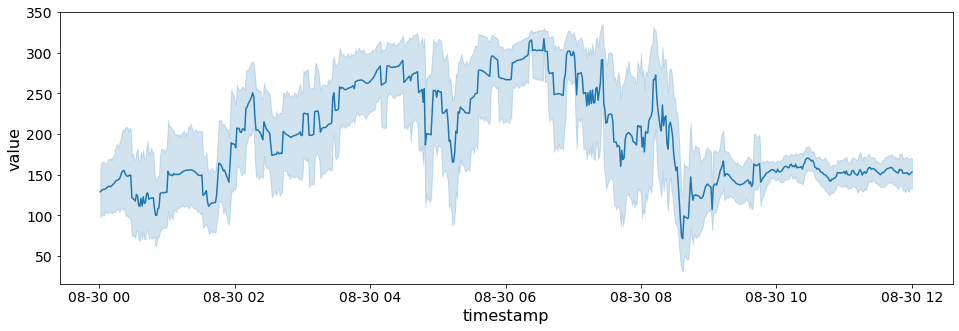

In [81]:
time_queries(signal = 'value', timestamp = 'timestamp', table = 'sg_wind_direction', prefix = '16_', dir_images = dir_images)

# 17_sg_wind_speed

Starting query at: 2020-12-10 22:08:27.052015.....
Finished query at: 2020-12-10 22:08:30.601309.
Query duration: 3 seconds.
Rows returned: 9582
Figure saved at:  images_data_exploration/17_sg_wind_speed_wind_speed_value_original_timestamp.png


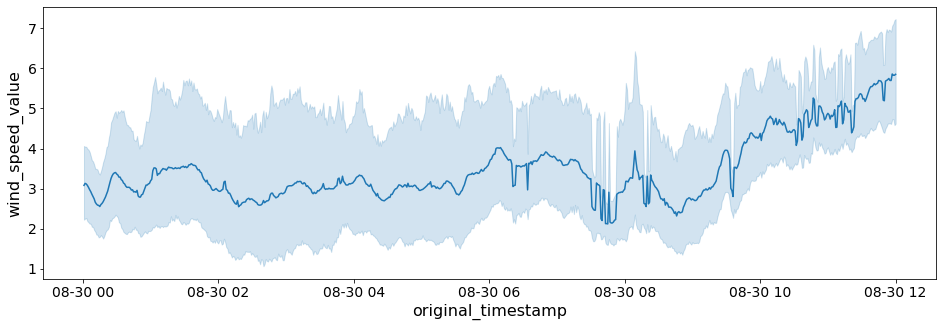

In [82]:
time_queries(signal = 'wind_speed_value', timestamp = 'original_timestamp', table = 'sg_wind_speed', prefix = '17_', dir_images = dir_images)